# P10. Answering Business Questions using SQL

In this project we are going to practice some SQL skills and apply some pandas visualizations to answer business questions using the Chinook database. A database containing different tables regarding customer purchase behavior from the music industry, as well as track, and invoice information.



In [86]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

#takes a SQL query as an argument and returns a pandas df
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
#takes a SQL command as an argument and executes it using the sqlite module   
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

#function that calls the run_query() function to return a list of 
#all tables and views in the database
def show_tables():
    q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view")'
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Best Albums

Out of a list of albums, select which genre will sell the best in the USA.

In [78]:
tracks_sold = '''with usa_tracks as
                (select count(*) from invoice_line as il
                inner join invoice as i on i.invoice_id = il.invoice_id
                inner join customer as c on c.customer_id = i.customer_id
                where c.country = 'USA'
                ) 
                select 
                g.name as genre, count(il.invoice_id) as tracks_sold, 
                100*cast(count(il.invoice_id) as float)/(select * from usa_tracks) as pct_total 
                from invoice_line as il 
                inner join track as t on t.track_id = il.track_id 
                left join genre as g on t.genre_id = g.genre_id 
                inner join invoice as i on i.invoice_id = il.invoice_id 
                inner join customer as c on c.customer_id = i.customer_id 
                where c.country = 'USA'
                group by genre 
                order by 2 desc
                '''

df_genre = run_query(tracks_sold)
df_genre

,genre,tracks_sold,pct_total
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


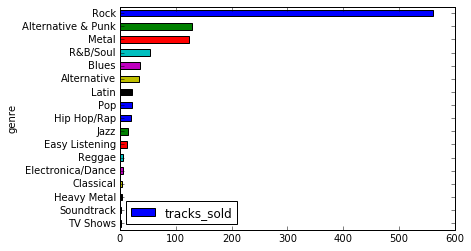

In [79]:
df_genre.plot(kind='barh', x = 'genre',y ='tracks_sold').invert_yaxis()


From the previous chart we can see which genres are the most popular. We would recommend the store to sell Rock, Alternative & Punk, and Metal.

# Analyzing Employee Sales Performance 

Analyze the purchases of customers belonging to each employee, and determine if any sales support agent is performing better than others.

In [80]:
sales_perf = '''
            select e.first_name || ' ' || e.last_name as employee_name,
            sum(i.total) as total_amount, count(i.invoice_id) as total_sales
            from invoice as i 
            left join customer as c on c.customer_id = i.customer_id
            left join employee as e on c.support_rep_id = e.employee_id
            where e.title like '%sales%'
            group by employee_name
            order by total_amount desc
            '''
employee_sales = run_query(sales_perf)
employee_sales


,employee_name,total_amount,total_sales
0,Jane Peacock,1731.51,212
1,Margaret Park,1584.00,214
2,Steve Johnson,1393.92,188


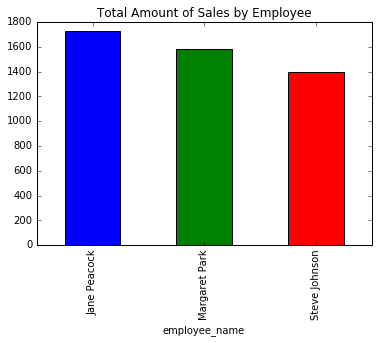

In [81]:
employee_sales.set_index("employee_name", inplace=True, drop=True)
employee_sales['total_amount'].plot(kind='bar')
plt.title('Total Amount of Sales by Employee')



From the previous bar chart we can see that Jane Peacock has sold the most in dollar amount.



# Analyzing Sales by Country


In [176]:
country_other = '''
                with all_countries AS 
                (
                select c.customer_id, il.unit_price, i.invoice_id,
                case when (select count(*) from customer where country = c.country) = 1 then 'Other'
                else c.country end as country_cat
                from invoice_line as il
                inner join invoice as i on i.invoice_id = il.invoice_id
                inner join customer as c on c.customer_id = i.customer_id
                )
                select ac.country_cat, count(distinct ac.customer_id) as total_customers,
                    sum(ac.unit_price) as total_sales, sum(ac.unit_price)/count(distinct ac.customer_id) as avg_sales_per_cust,
                    sum(ac.unit_price)/count(distinct ac.invoice_id) as avg_order_value,
                    case when ac.country_cat = 'Other' then 1
                    else 0 end as sort
                    from all_countries as ac
                    group by ac.country_cat
                    order by sort asc, total_sales desc

              '''
sales_by_country = run_query(country_other)
sales_by_country
                    

,country_cat,total_customers,total_sales,avg_sales_per_cust,avg_order_value,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


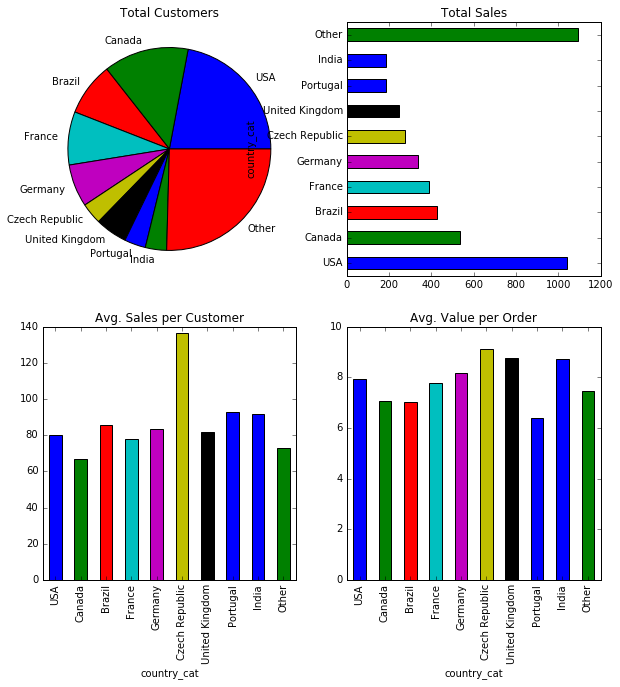

In [198]:
#sales_by_country.set_index('country_cat', drop=True, inplace=True)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize =(10,10))
ax1 = plt.subplot(221)
ax1 = sales_by_country['total_customers'].plot(kind='pie')
plt.ylabel('')
ax1.set_title ('Total Customers')

ax2 = plt.subplot(222)
ax2 = sales_by_country['total_sales'].plot(kind='barh')
ax2.set_title('Total Sales')

ax3 = plt.subplot(223)
ax3 = sales_by_country['avg_sales_per_cust'].plot(kind = 'bar')
ax3.set_title('Avg. Sales per Customer')

ax4 = plt.subplot(224)
ax4 = sales_by_country['avg_order_value'].plot(kind = 'bar')
ax4.set_title('Avg. Value per Order')

# Analyzing Albums vs Individual Tracks

In [199]:
invoices = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''
run_query(invoices)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
